## FMRP and Translational Regulation Analysis
Used for Figure 4

Author: Max Gold

In [8]:
## Import packages
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import quantile_transform

In [9]:
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"

### Load data

In [10]:
base_folder = '../data/'

In [11]:
pdf = pd.read_csv(os.path.join(base_folder, "archer_prot_norm.csv.gz"), compression='gzip', index_col=0)
rdf= pd.read_csv(os.path.join(base_folder, "archer_rna_norm.csv.gz"), compression='gzip', index_col=0)

## Load metadata
mdf = pd.read_excel(os.path.join(base_folder, "Archer_metadata.xlsx"), index_col=0)

shha_samp = mdf[mdf['Proteome']=='SHHa'].index.tolist()
shhb_samp = mdf[mdf['Proteome']=='SHHb'].index.tolist()

### Generate Plots for Fig 2B for Marker genes

In [13]:
pm = pdf.melt(ignore_index=False)
pm['Sample'] = list(pm.index)
pm = pm.join(mdf['Proteome'])
target_genes = ['NEUROD1', 'SEMA6A', 'DLG4', 'PCLO']

pm.index = range(len(pm))
pm = pm[pm['Proteome'].str.contains('SHH')]
pm = pm[pm['variable'].isin(target_genes)]
pm.columns = ['Gene', 'Relative Protein Expression','Sample', 'Subtype']

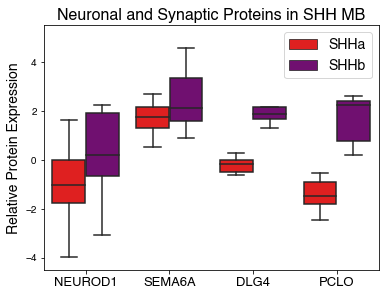

In [14]:
## make plot
fig,ax = plt.subplots(figsize=(6,4.5))
sns.boxplot(data=pm, x='Gene', y='Relative Protein Expression', hue='Subtype',
                 showfliers=False, palette=['red', 'purple'], order = target_genes, ax=ax)
ax.set_title("Neuronal and Synaptic Proteins in SHH MB", fontsize=16)
ax.set_xlabel("")
ax.set_ylim(-4.5, 5.5)
ax.set_ylabel('Relative Protein Expression',fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
ax.legend(fontsize=14)

# plt.savefig("pdf_arial_figures/fig4a-protmark.pdf", dpi=300, bbox_inches='tight')

In [5]:
### statistical tests comparing A and B for these genes
for gene in target_genes:
    a = pm[(pm['Subtype']=='SHHa') & (pm['Gene']==gene)]['Relative Protein Expression']
    b = pm[(pm['Subtype']=='SHHb')& (pm['Gene']==gene)]['Relative Protein Expression']
    t,p = stats.ttest_ind(a,b)
    print(gene, t, p)

NEUROD1 -1.1167456618695903 0.28431875529327094
SEMA6A -1.4629416033555434 0.167237598825962
DLG4 -8.153897097783979 1.8139952217777442e-06
PCLO -6.87920995157286 1.1197906039326892e-05


In [7]:
## neurod1 and sema6a are not significant while DLG4 and PCLO are

### FMRP analysis

In [15]:
## Load annotation datasets
fmrp_df = pd.read_excel(os.path.join(base_folder, "darnell_2011_fmrp_list.xlsx"), index_col = 0, header = 0)
fmrp_genes = list(fmrp_df['Gene Symbol'])

go_syn = [x.rstrip() for x in open(os.path.join(base_folder, "go_synapse.txt"))][2:]

In [16]:
## rank normalize the data
## quantile transform
def get_qt(xdf):
    return pd.DataFrame(quantile_transform(xdf.copy(), n_quantiles=xdf.shape[1], random_state=0, axis=1, output_distribution='uniform'), index=xdf.index, columns=xdf.columns)

genes = sorted(set(pdf.columns).intersection(rdf.columns))

qpdf = get_qt(pdf[genes])
qrdf = get_qt(rdf[genes])

/Users/maxgold/opt/anaconda3/envs/clean_v2/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2553: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing.data` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)
/Users/maxgold/opt/anaconda3/envs/clean_v2/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2553: FutureWarning: The default value of `copy` will change from False to True in 0.23 in order to make it more consistent with the default `copy` values of other functions in :mod:`sklearn.preprocessing.data` and prevent unexpected side effects by modifying the value of `X` inplace. To avoid inplace modifications of `X`, it is recommended to explicitly set `copy=True`
  FutureWarning)


In [17]:
## get everything onto -0.5 to 0.5 scale
shh_samp = set(mdf[mdf['Consensus']=='SHH'].index).intersection(qpdf.index).intersection(qrdf.index)
# genes = set(qpdf.columns).intersectio
sqp = qpdf.loc[shh_samp] - 0.5
sqr = qrdf.loc[shh_samp] - 0.5
sqd = sqp - sqr

In [18]:
## Create gene annotation dictionary
## Annotations
smdf = mdf.loc[shh_samp]
shh_dict = dict([[index, row['Proteome']] for index,row in smdf.iterrows()])

gene_dict = dict()
for gene in genes:    
    if gene in go_syn:
        base = 'SYN'
    else:
        base = 'Non-SYN'
    if gene in fmrp_genes:
        add = '-FMRP'
    else:
        add = ''
    gene_dict[gene] = base + add

In [19]:
## calculate mean values for each gene for each subtype
sqpm = sqp.copy().join(mdf[["Proteome"]]).groupby("Proteome").mean()
sqrm = sqr.copy().join(mdf[["Proteome"]]).groupby("Proteome").mean()
sqdm = sqd.copy().join(mdf[["Proteome"]]).groupby("Proteome").mean()

In [20]:
def process_samps(s, assay):
    msqd = s.melt(ignore_index=False)
    msqd['Sample'] = list(msqd.index)
    msqd.columns = ['Gene', 'Value', 'Subtype']
    msqd['GeneType'] = [gene_dict[x] for x in msqd['Gene']]
    msqd['Subgroup'] = [shh_dict[x] for x in msqd['Sample']]
    msqd['Synaptic'] = ['Non-SYN' if 'Non-SYN' in x else 'SYN' for x in msqd['GeneType']]
    msqd['FMRP'] = ['FMRP' if 'FMRP' in x else 'non-FMRP' for x in msqd['GeneType']]
    msqd['Assay'] = assay
    
    return msqd, msqd[msqd['Subgroup']=='SHHa'], msqd[msqd['Subgroup']=='SHHb']

def process_means(s, assay):
    msqd = s.melt(ignore_index=False)
    msqd['Subtype'] = list(msqd.index)
    msqd.columns = ['Gene', 'Value', 'Subtype']
    msqd['GeneType'] = [gene_dict[x] for x in msqd['Gene']]
    msqd['Synaptic'] = ['Non-SYN' if 'Non-SYN' in x else 'SYN' for x in msqd['GeneType']]
    msqd['FMRP'] = ['FMRP' if 'FMRP' in x else 'non-FMRP' for x in msqd['GeneType']]
    msqd['Assay'] = assay
    return msqd, msqd[msqd['Subtype']=='SHHa'], msqd[msqd['Subtype']=='SHHb']

In [21]:
## get values for all samples and then just SHHa and SHHb
r, ra, rb = process_means(sqrm, 'RNA')
p, pa, pb = process_means(sqpm, 'Protein')
d, da, db = process_means(sqdm, 'RankDiff')

### Prot - RNA differences for synaptic genes in SHHb

In [22]:
## SHHb synaptic

In [23]:
print(np.mean(db[db['Synaptic']=='SYN']['Value']))

print(np.mean(db[db['Synaptic']=='Non-SYN']['Value']))

0.07894490146832515
-0.008331170900552812


In [24]:
## synaptic 

In [25]:
stats.ttest_1samp(db[db['Synaptic']=='SYN']['Value'], 0)

Ttest_1sampResult(statistic=14.110529788496793, pvalue=1.1410849986593114e-40)

In [26]:
## SHHb non-synaptic

In [27]:
stats.ttest_1samp(db[db['Synaptic']=='Non-SYN']['Value'], 0)

Ttest_1sampResult(statistic=-4.195795986311919, pvalue=2.749117405989501e-05)

### Prot - RNA differences for synaptic genes in SHHa

In [28]:
print(pa[pa['Synaptic']=='SYN'].mean())
print(pa[pa['Synaptic']=='Non-SYN'].mean() )

Value   -0.07565
dtype: float64
Value    0.007983
dtype: float64


/Users/maxgold/opt/anaconda3/envs/clean_v2/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.
/Users/maxgold/opt/anaconda3/envs/clean_v2/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [29]:
## synaptic 

In [30]:
stats.ttest_1samp(da[da['Synaptic']=='SYN']['Value'], 0)

Ttest_1sampResult(statistic=-6.773507439213837, pvalue=2.3849701687952886e-11)

In [31]:
## SHHb non-synaptic

In [32]:
stats.ttest_1samp(da[da['Synaptic']=='Non-SYN']['Value'], 0)

Ttest_1sampResult(statistic=2.1152158409683977, pvalue=0.03444299338041773)

## Plot Synaptic vs. Non-Synaptic

In [33]:
big_a = ra.append(pa).append(da)
big_b = rb.append(pb).append(db)

### SHHb

Text(0.5, 1.0, 'SHHb Ranks by Data Type and Synapse Status')

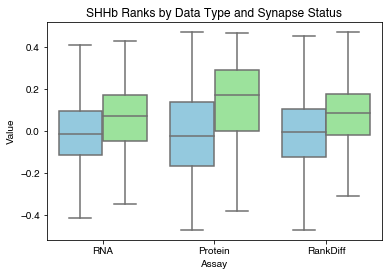

In [34]:
plt.figure()
ax = sns.boxplot(data=big_b, x='Assay', y='Value', hue='Synaptic',  showfliers = False, palette=['skyblue', 'lightgreen'])
ax.get_legend().remove()
ax.set_title("SHHb Ranks by Data Type and Synapse Status")
# plt.savefig("../fig4s-shhb -syn.png", dpi=300, bbox_inches='tight')

### SHHa

Text(0.5, 1.0, 'SHHa Ranks by Data Type and Synapse Status')

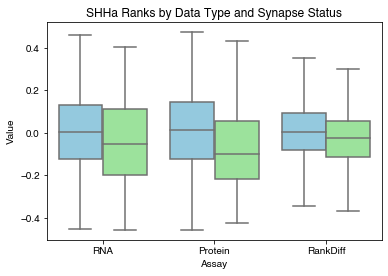

In [35]:
plt.figure()
ax = sns.boxplot(data=big_a, x='Assay', y='Value', hue='Synaptic',  showfliers = False, palette=['skyblue', 'lightgreen'])
ax.get_legend().remove()
ax.set_title("SHHa Ranks by Data Type and Synapse Status")
# plt.savefig("../fig4s-shha-syn.png", dpi=300, bbox_inches='tight')

### Figure 4D

In [36]:
ho = ['Non-SYN', 'Non-SYN-FMRP', 'SYN', 'SYN-FMRP']

In [37]:
bp = ['lightskyblue','dodgerblue', 'springgreen','green' ]

(-0.6, 0.7)

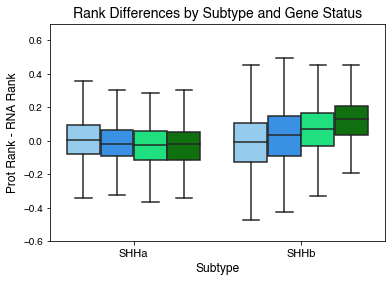

In [38]:
plt.figure()
ax = sns.boxplot(data=d, x='Subtype', y='Value', hue='GeneType',  showfliers = False, hue_order = ho, palette=bp )
ax.get_legend().remove()
ax.set_ylabel("Prot Rank - RNA Rank", fontsize=12)
ax.set_xlabel("Subtype", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
ax.set_title("Rank Differences by Subtype and Gene Status", fontsize=14)
ax.set_ylim(-0.6, 0.7)
# plt.savefig("pdf_arial_figures/fig4d-fmrp.pdf", dpi=300, bbox_inches='tight')